# Data preparation for the UN SDG Indicators

**We use UN SDG's data set and convert this data set, so every country, continent, etc. is in a separate <code>csv</code> file.**

To get started, we download the entire available data from https://unstats.un.org/sdgs/indicators/database/ and call it <code>un_data.csv</code>.


Let's load the data set and look at its columns and rows to figure out how it is structured.


**We aim to have one pandas data frame per country, with all indicators. We save them as separate <code>csv</code> files.** 

Let's start with the usual imports and loading the data set.

In [69]:
import numpy as np
import pandas as pd
import math
import os
import pickle
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [94]:
# loading data set
all_data = pd.read_csv('un_data.csv', dtype=object)
all_data.tail()

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,[Policy Domains],[Quantile],[Reporting Type],[Sex],[Tariff regime (status)],[Type of mobile technology],[Type of occupation],[Type of product],[Type of skill],[Type of speed]
1104995,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2013,85.76164,2013,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104996,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2014,125.47225,2014,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104997,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2015,94.86903,2015,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104998,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2016,93.93723,2016,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104999,17,17.9,17.9.1,DC_FTA_TOTAL,Total official development assistance (gross d...,894,Zambia,2017,98.11231,2017,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data set is structured by indicators and years in rows in one large data frame with all countries. We would like to have one data frame per country. Hence, we first extract the names of *regional groupings*, i.e. countries, continents, etc., and the names of so-called *other groupings*.

According to the UN Statistics Division, other groupings include Least Developed Countries (LDC), Land Locked Developing Countries (LLDC), Small Island Developing States (SIDS), Developed Regions, and Developing Regions. 

Developing Regions are Latin America and the Caribbean, South-Eastern Asia, Southern Asia, Southern Asia (excluding India), Caucasus and Central Asia, Eastern Asia (excluding Japan and China), Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia), Eastern Asia (excluding Japan), Oceania (exc. Australia and New Zealand), Sub-Saharan Africa (inc. Sudan), and Northern Africa (exc. Sudan).

**All these groupings can be subject to separate network analyses of the indicators later on.**




Let's first see all different columns of our data frame before we only see these different groupings.

In [95]:
list(all_data)

['Goal',
 'Target',
 'Indicator',
 'SeriesCode',
 'SeriesDescription',
 'GeoAreaCode',
 'GeoAreaName',
 'TimePeriod',
 'Value',
 'Time_Detail',
 ' UpperBound',
 ' LowerBound',
 ' BasePeriod',
 ' Source',
 'FootNote',
 'Nature',
 'Units',
 '[Age]',
 '[Cities]',
 '[Disability status]',
 '[Education level]',
 '[IHR Capacity]',
 '[Level/Status]',
 '[Location]',
 '[Migratory status]',
 '[Mode of transportation]',
 '[Name of international institution]',
 '[Name of non-communicable disease]',
 '[Policy Domains]',
 '[Quantile]',
 '[Reporting Type]',
 '[Sex]',
 '[Tariff regime (status)]',
 '[Type of mobile technology]',
 '[Type of occupation]',
 '[Type of product]',
 '[Type of skill]',
 '[Type of speed]']

We have even lots of information on a sub-indicator level and this might be subject to more detailed analyses later on. We could, e.g., indicator 4.6.1* explore by disparate age goups and by sex.

\* *Indicator 4.6.1: Proportion of population in a given age group achieving at least a fixed level of proficiency in functional (a) literacy and (b) numeracy skills, by sex.*


We keep this possibility open, but now, let's not go further into a sub-indicator level and see the different groupings.

In [96]:
groupings = all_data['GeoAreaName'].unique()
groupings.tolist()

['World',
 'South America',
 'Albania',
 'Oceania',
 'Western Africa',
 'Algeria',
 'Central America',
 'Eastern Africa',
 'Northern Africa',
 'Middle Africa',
 'Southern Africa',
 'Northern America',
 'Angola',
 'Caribbean',
 'Eastern Asia',
 'Azerbaijan',
 'Argentina',
 'Southern Asia',
 'South-Eastern Asia',
 'Australia',
 'Southern Europe',
 'Austria',
 'Bangladesh',
 'Armenia',
 'Australia and New Zealand',
 'Melanesia',
 'Belgium',
 'Polynesia',
 'Central and Southern Asia',
 'Bhutan',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Belize',
 'Solomon Islands',
 'Bulgaria',
 'Myanmar',
 'Burundi',
 'Belarus',
 'Cameroon',
 'Canada',
 'Cabo Verde',
 'Caucasus and Central Asia',
 'Central African Republic',
 'Asia',
 'Central Asia',
 'Sri Lanka',
 'Western Asia',
 'Chad',
 'Europe',
 'Eastern Europe',
 'Chile',
 'Northern Europe',
 'Western Europe',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Democratic Republic of the Congo',
 'Costa Ri

We convert the data set into multiple small data sets by creating a dictionary that contains the groupings' names as keys. 

First, we create empty data frames for each key.

In [97]:
dict_all = {group: pd.DataFrame() for group in groupings}

In [98]:
# check, should be empty
dict_all.get('Belize')

""


Second, we replace each of the empty data frames with the data we have available for them. Note, that our dictionary will be the ensamble of all groupings.

In [99]:
for group in groupings:    # memory-intensive
    dict_all[group] = all_data[all_data['GeoAreaName'].isin(['{}'.format(group)])]

In [100]:
# check
dict_all['Belize']

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,[Policy Domains],[Quantile],[Reporting Type],[Sex],[Tariff regime (status)],[Type of mobile technology],[Type of occupation],[Type of product],[Type of skill],[Type of speed]
345,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,84,Belize,1993,10.1,1993,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
346,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,84,Belize,1994,9.9,1994,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,84,Belize,1996,13.3,1996,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,84,Belize,1997,16,1997,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,84,Belize,1998,14.4,1998,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,84,Belize,1999,13.9,1999,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12580,1,1.3,1.3.1,SI_COV_SOCAST,[World Bank] Proportion of population covered ...,84,Belize,2009,16.27566,2009,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12919,1,1.3,1.3.1,SI_COV_SOCASTPQ,[World Bank] Poorest quintile covered by socia...,84,Belize,2009,18.49964,2009,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13257,1,1.3,1.3.1,SI_COV_SOCINS,[World Bank] Proportion of population covered ...,84,Belize,2009,28.18954,2009,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13683,1,1.3,1.3.1,SI_COV_SOCINSPQ,[World Bank] Poorest quintile covered by socia...,84,Belize,2009,29.36916,2009,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we have one data frame per country. The next step is to have years as columns.

The next cell gives us the series codes in the rows and the years in the columns. These series codes are unique descriptions of the sub-indicators and we match these series codes to indicators and all other information in a different data frame.

In [101]:
for group in groupings:
    dict_all[group] = dict_all.get(group).pivot_table(values='Value', index='SeriesCode', columns='TimePeriod', dropna=False, aggfunc='first')

In [102]:
# check
dict_all['Guam'].head()

TimePeriod,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
SeriesCode,,,,,,,,,,,,,,,,,,,,,
AG_FPA_CFPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG_FPA_COMM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG_LND_DGRD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG_LND_FRST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.2963,NaN,NaN,NaN,NaN,46.2963,NaN,NaN,NaN,NaN
AG_LND_FRSTBIOPHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112,NaN,NaN,NaN,NaN,112,NaN,NaN,NaN,NaN


Let's now save a data frame with all of the meta-information. We delete the columns which are specific in area and time, and of course we do not want to have the values in this data frame. In the end, we delete all duplicate entries in the column **SeriesCode**. So, we are left with the information we wanted: mapping the series codes to the indicators, the Source for the data, the Units measured in, etc.

In [109]:
info = all_data.drop(columns=['GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value', 'Time_Detail']).drop_duplicates(subset=['Indicator', 'SeriesCode'])

In [110]:
# check
info.head()

,Goal,Target,Indicator,SeriesCode,SeriesDescription,UpperBound,LowerBound,BasePeriod,Source,FootNote,...,[Policy Domains],[Quantile],[Reporting Type],[Sex],[Tariff regime (status)],[Type of mobile technology],[Type of occupation],[Type of product],[Type of skill],[Type of speed]
0,1,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,NaN,NaN,NaN,"World Development Indicators database, World Bank","Retrieved on March 20, 2019 from World Bank, P...",...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1822,1,1.1,1.1.1,SI_POV_EMP1,Employed population below international povert...,NaN,NaN,NaN,"ILO estimates, November 2018, available in ILO...",NaN,...,NaN,NaN,G,BOTHSEX,NaN,NaN,NaN,NaN,NaN,NaN
10993,1,1.2,1.2.1,SI_POV_NAHC,Proportion of population living below the nati...,NaN,NaN,NaN,"World Development Indicators database, World Bank",Source: National Statictis and Information Aut...,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12365,1,1.3,1.3.1,SI_COV_MATNL,[ILO] Proportion of mothers with newborns rece...,NaN,NaN,NaN,ILO estimates based on country data compled th...,NaN,...,NaN,NaN,G,BOTHSEX,NaN,NaN,NaN,NaN,NaN,NaN
12472,1,1.3,1.3.1,SI_COV_POOR,[ILO] Proportion of poor population receiving ...,NaN,NaN,NaN,ILO Social Security Inquiry (SSI). Available a...,ILO estimates based on country data,...,NaN,NaN,G,BOTHSEX,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning up and transforming all country data frames into the same dimensions

We have a couple of things to do to make our data frames workable:
1. We have some values in the data frames which we do not want, as e.g. <code>,</code>, <code> = </code>, <code>N</code>, etc. We replace them with appropriate values, i.e. <code>0</code>, or simply a space. 
2. Some data frames have data from **1990** to **2018**, some others from **1992** to **2018**. We want to have all data frames having data from **1990** to **2018**, i.e. an equal amount of columns. The additional columns are filled with <code>NaNs</code>.
3. Some data frames have not all indicators and sub-indicators listed, but we would like to have all of them in all data frames. These additional rows are filled with <code>NaNs</code>.

Let's start with the first task, i.e. cleaning up the data frames.

We first need to define lists for all years, i.e. **1990** to **2018** and all indicators and sub-indicators, i.e. series codes.

In [112]:
# list of all years
years = list(dict_all['France'])    # France is an example of a country that has all columns
years

['1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

Change <span style="color:red"> 'Guam' </span> in the cell below to a few other countries and you'll see that they can have different lengths. We need to bring all on the same length. We agree on having data for the **years 1990 to 2018**.

Now, we insert the missing years for all groupings. We want to have NaNs in those columns.

In [113]:
# example
list(dict_all['Guam'])

['1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

In [114]:
# list of all series codes
seriescodes = list(info['SeriesCode'])
seriescodes

['SI_POV_DAY1',
 'SI_POV_EMP1',
 'SI_POV_NAHC',
 'SI_COV_MATNL',
 'SI_COV_POOR',
 'SI_COV_SOCAST',
 'SI_COV_SOCASTPQ',
 'SI_COV_SOCINS',
 'SI_COV_CHLD',
 'SI_COV_SOCINSPQ',
 'SI_COV_UEMP',
 'SI_COV_VULN',
 'SI_COV_WKINJRY',
 'SI_COV_BENFTS',
 'SI_COV_DISAB',
 'SI_COV_LMKT',
 'SI_COV_LMKTPQ',
 'SI_COV_PENSN',
 'SP_ACS_BSRVH2O',
 'SP_ACS_BSRVSAN',
 'VC_DSR_GDPLS',
 'VC_DSR_MISS',
 'VC_DSR_AFFCT',
 'VC_DSR_MORT',
 'VC_DSR_MTMP',
 'VC_DSR_MTMN',
 'VC_DSR_DAFF',
 'VC_DSR_IJILN',
 'VC_DSR_PDAN',
 'VC_DSR_PDYN',
 'VC_DSR_PDLN',
 'SG_DSR_LGRGSR',
 'SG_DSR_SILS',
 'SG_DSR_SILN',
 'SG_GOV_LOGV',
 'VC_DSR_LSGP',
 'VC_DSR_AGLN',
 'VC_DSR_HOLN',
 'VC_DSR_CILN',
 'VC_DSR_CHLN',
 'VC_DSR_DDPA',
 'SD_XPD_ESED',
 'SN_ITK_DEFC',
 'AG_PRD_FIESSI',
 'AG_PRD_FIESSIN',
 'SN_ITK_DEFCN',
 'SH_STA_STUNT',
 'SH_STA_STUNTN',
 'SH_STA_WASTE',
 'SH_STA_WASTEN',
 'SH_STA_OVRWGT',
 'SH_STA_OVRWGTN',
 'PD_AGR_SSFP',
 'SI_AGR_SSFP',
 'ER_GRF_ANIMRCNT',
 'ER_GRF_PLNTSTOR',
 'ER_RSK_LBREDS',
 'AG_PRD_ORTIND',
 'DC_TOF_A

In [115]:
# count how many we have
len(seriescodes)

436

Firstly, we insert the missing years as columns for all groupings.

In [116]:
for group in groupings:    # memory-intensive
    for year in years:
        if year not in list(dict_all[group]):
            dict_all[group]['{}'.format(year)] = np.nan
    # having the years in order
    dict_all[group] = dict_all[group][['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]

In [117]:
# check
dict_all['Guam'].head()

TimePeriod,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
SeriesCode,,,,,,,,,,,,,,,,,,,,,
AG_FPA_CFPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG_FPA_COMM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG_LND_DGRD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG_LND_FRST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.2963,NaN,NaN,NaN,NaN,46.2963,NaN,NaN,NaN,NaN
AG_LND_FRSTBIOPHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112,NaN,NaN,NaN,NaN,112,NaN,NaN,NaN,NaN


Secondly, we insert the missing series codes as rows.

Let's first see how many rows do we have for <span style="color:red"> Guam </span>?

In [118]:
len(list(dict_all['Guam'].index))

78

Let's have all $J$ sub-indicators we want for each country as rows. We fill these rows with NaNs. 

In [119]:
for group in groupings:        # memory-intensive
    for seriescode in seriescodes:
        if seriescode not in list(dict_all[group].index):
            dict_all[group].loc[seriescode] = np.nan    # fill these rows with NaNs

In [120]:
# check: do we have J many?
len(list(dict_all['Guam'].index))

391

In [121]:
# convert all to floats
for group in groupings:
    for year in years:    
        for seriescode in seriescodes:
            if not isinstance(dict_all[group].loc[seriescode, year], float):
                dict_all[group].loc[seriescode, year] = float(dict_all[group].loc[seriescode, year].replace(',', '').replace('<', '').replace('>', '').replace('=', '').replace('N', '0').replace(' -   ', '0').replace('0V', '0').replace('. . .', '0'))

In [122]:
# double-check: are all series codes as rows?
list(dict_all['Guam'].index)

['AG_FPA_CFPI',
 'AG_FPA_COMM',
 'AG_LND_DGRD',
 'AG_LND_FRST',
 'AG_LND_FRSTBIOPHA',
 'AG_LND_FRSTCERT',
 'AG_LND_FRSTCHG',
 'AG_LND_FRSTMGT',
 'AG_LND_FRSTN',
 'AG_LND_FRSTPRCT',
 'AG_LND_TOTL',
 'AG_PRD_AGVAS',
 'AG_PRD_FIESSI',
 'AG_PRD_FIESSIN',
 'AG_PRD_ORTIND',
 'AG_XPD_AGSGB',
 'EG_ELC_ACCS',
 'EG_FEC_RNEW',
 'EG_TBA_H2CO',
 'EG_TBA_H2COAQ',
 'EG_TBA_H2CORL',
 'EN_WBE_PMNR',
 'EN_WBE_PMPN',
 'EN_WBE_PMPP',
 'EN_WBE_PMPR',
 'ER_CBD_ORSPGRFA',
 'ER_CBD_PTYPGRFA',
 'ER_GRF_ANIMRCNT',
 'ER_H2O_STRESS',
 'ER_H2O_WUEYST',
 'ER_MRN_MARIN',
 'ER_MRN_MARINT',
 'ER_MRN_MPA',
 'ER_MTN_GRNCOV',
 'ER_MTN_GRNCVI',
 'ER_MTN_TOTL',
 'ER_PTD_TERRS',
 'ER_REG_SSFRAR',
 'ER_REG_UNFCIM',
 'ER_RSK_LBREDS',
 'ER_RSK_LSTI',
 'GB_POP_SCIERD',
 'GB_XPD_RSDV',
 'IS_RDP_FRGVOL',
 'IS_RDP_PFVOL',
 'IT_MOB_NTWK',
 'IT_NET_BBN',
 'IT_NET_BBP',
 'IT_USE_ii99',
 'PD_AGR_SSFP',
 'SG_CPA_MIGR',
 'SG_GEN_LOCGELS',
 'SG_REG_BRTH90N',
 'SG_REG_CENSUSN',
 'SG_REG_DETH75N',
 'SH_H2O_SAFE',
 'SH_SAN_DEFECT',
 'SH_TBS

Finally, we can save all countries as different <code>csv</code> files and as one `dict`.

In [123]:
if not os.path.exists('csv_original'):
    os.mkdir('csv_original')

In [124]:
for group in groupings:
    dict_all[group].to_csv(r'csv_original/{}.csv'.format(group))

Having the information file might also be helpful.

In [125]:
if not os.path.exists('utils'):
    os.mkdir('utils')
    
info.to_csv(r'utils/info.csv')

In [126]:
# as one pickle file
dictall = open('utils/dict_all.pkl', 'wb')
pickle.dump(dict_all, dictall)
dictall.close()

In [127]:
# CHECKPOINT
dictall = open('utils/dict_all.pkl', 'rb')
dict_all = pickle.load(dictall)
dictall.close()

## Visualising time-series

We quickly visualise the time-series to get a better idea of the characteristics of our data set.

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


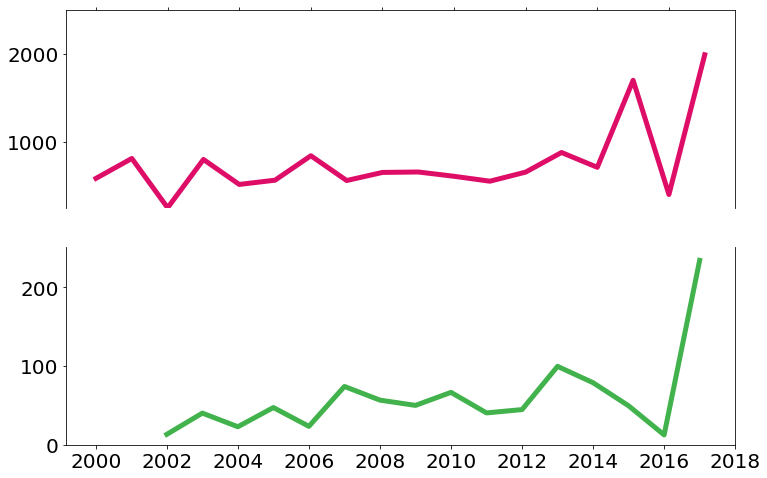

In [136]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
ax2.plot(list(range(1990, 2020)), dict_all['Bolivia (Plurinational State of)'].loc['DC_ODA_BDVL'], color='#42B24C', linewidth=5)
ax.plot(list(range(1990, 2020)), dict_all['Bolivia (Plurinational State of)'].loc['DC_TRF_TOTL'], color='#DE0E68', linewidth=5)

ax2.set_ylim(0, 251)  # biodiversity ODA
ax.set_ylim(250, 2501)  # total ODA

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labelsize=20, labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

plt.xticks(np.arange(2000, 2019, step=2), size=20)
ax2.tick_params(labelsize=20)

f.set_figheight(8)
f.set_figwidth(12)

plt.show()

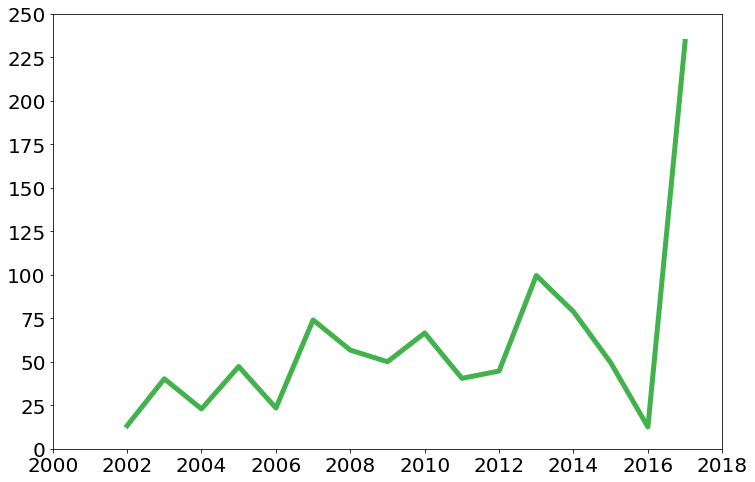

In [137]:
plt.figure(figsize=(12,8))
plt.plot(list(range(1990, 2020)), dict_all['Bolivia (Plurinational State of)'].loc['DC_ODA_BDVL'], color='#42B24C', linewidth=5)
plt.xticks(np.arange(2000, 2019, step=2), size=20)
plt.yticks(np.arange(0, 251, step=25), size=20)
plt.show()

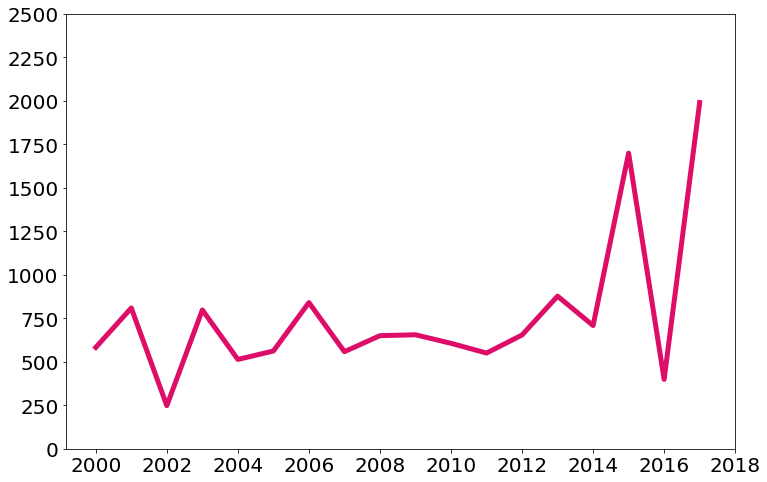

In [138]:
plt.figure(figsize=(12,8))
plt.plot(list(range(1990, 2020)), dict_all['Bolivia (Plurinational State of)'].loc['DC_TRF_TOTL'], color='#DE0E68', linewidth=5)
plt.xticks(np.arange(2000, 2019, step=2), size=20)
plt.yticks(np.arange(0, 2501, step=250), size=20)
plt.show()

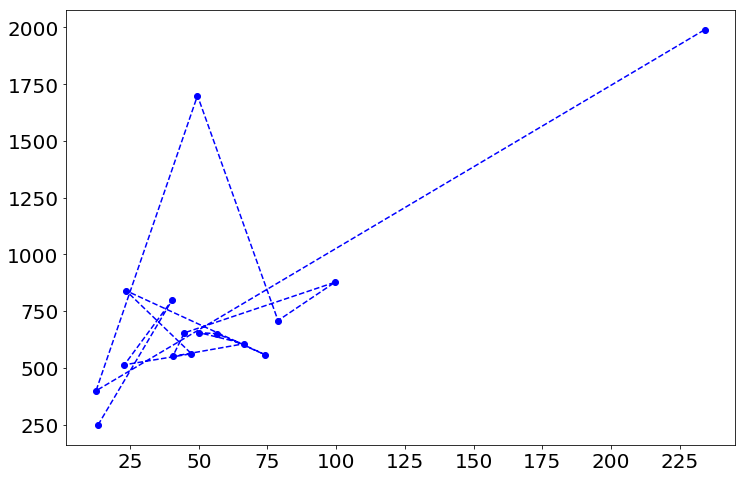

In [139]:
plt.figure(figsize=(12,8))
plt.yticks(np.arange(0, 2001, step=250), size=20)
plt.xticks(np.arange(0, 251, step=25), size=20)
plt.plot(dict_all['Bolivia (Plurinational State of)'].loc['DC_ODA_BDVL'], dict_all['Bolivia (Plurinational State of)'].loc['DC_TRF_TOTL'], '--bo') #, s=100, color='black')

## Data standardisation
We have saved the original data set, but it is often useful to have the data standardised. Standardising a data set involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1. Standardisation is often required by machine learning algorithms when your time series data has input values with differing scales. 

We create a new dictionary `dict_all_std` to keep the standardised values separate to the original ones.

In [ ]:
# CHECKPOINT (we don't want to re-run the entire script every time we continue working on it)
dict_all = pickle.load(open('utils/dict_all.pkl', 'rb'))
dict_all_std = pickle.load(open('utils/dict_all_std.pkl', 'rb'))

In [132]:
# memory-intensive (~3 hours computing time)
dict_all_std = copy.deepcopy(dict_all)    
mean = {}
std = {}

for group in groupings:
    for seriescode in seriescodes:
        # adding noise as representative for measurement errors
        noise = np.random.normal(size=len(dict_all[group].loc[seriescode]))
        
        dict_all[group].loc[seriescode] = dict_all[group].loc[seriescode] + noise
        
        mean[group, seriescode] = np.nanmean(list(dict_all[group].loc[seriescode]))    # np.nanmean ignores NaNs
        std[group, seriescode] = np.nanstd(list(dict_all[group].loc[seriescode]))
        
        for year in years:
            dict_all_std[group].loc[seriescode, year] = (dict_all[group].loc[seriescode, year] - mean[group, seriescode]) / std[group, seriescode]

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: Mean of empty slice
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [133]:
#check
print('Original value', dict_all['World'].loc['AG_LND_FRST'])
print('-------')
print('Standardised value', dict_all_std['World'].loc['AG_LND_FRST'])

Original value TimePeriod
1990        NaN
1991        NaN
1992        NaN
1993        NaN
1994        NaN
1995        NaN
1996        NaN
1997        NaN
1998        NaN
1999        NaN
2000    30.6072
2001        NaN
2002        NaN
2003        NaN
2004        NaN
2005    31.1318
2006        NaN
2007        NaN
2008        NaN
2009        NaN
2010    31.6845
2011        NaN
2012        NaN
2013        NaN
2014        NaN
2015    31.9366
2016        NaN
2017        NaN
2018        NaN
2019        NaN
Name: AG_LND_FRST, dtype: object
-------
Standardised value TimePeriod
1990         NaN
1991         NaN
1992         NaN
1993         NaN
1994         NaN
1995         NaN
1996         NaN
1997         NaN
1998         NaN
1999         NaN
2000      -1.427
2001         NaN
2002         NaN
2003         NaN
2004         NaN
2005   -0.405387
2006         NaN
2007         NaN
2008         NaN
2009         NaN
2010    0.670732
2011         NaN
2012         NaN
2013         NaN
2014         Na

We better save `dict_all_std`...

In [134]:
# as csv files per grouping
if not os.path.exists('csv_standardised'):
    os.mkdir('csv_standardised')
    
for group in groupings:
    dict_all_std[group].to_csv(r'csv_standardised/{}.csv'.format(group))

# as one pickle file
stand = open('utils/dict_all_std.pkl', 'wb')
pickle.dump(dict_all_std, stand)
stand.close()

... and `mean` and `std` to rescale our standardised data set later.

In [135]:
# mean
m = open('utils/mean.pkl', 'wb')
pickle.dump(mean, m)
m.close()

# std
st = open('utils/std.pkl', 'wb')
pickle.dump(std, st)
st.close()